# 1. Package importation

In [1]:
!pip install sacremoses

  Obtaining dependency information for sacremoses from https://files.pythonhosted.org/packages/0b/f0/89ee2bc9da434bd78464f288fdb346bc2932f2ee80a90b2a4bbbac262c74/sacremoses-0.1.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 4.5 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install torch


In [3]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. Data Loading

In [6]:
train_dataset = pd.read_csv('/kaggle/input/dataset-flowbert/training_data.csv')
test_dataset = pd.read_csv('/kaggle/input/dataset-flowbert/unlabelled_test_data.csv')

# 3. View Of the Data

In [7]:
train_dataset

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...,...
4795,4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,4797,"Et le premier samedi de chaque mois, venez ren...",A2
4798,4798,Les coûts liés à la journalisation n'étant pas...,C2


# 4. Label Encoding

In [8]:
from sklearn.preprocessing import LabelEncoder
# Creation of an encoder
label_encoder = LabelEncoder()

# Encoding of the training labels
train_dataset['difficulty'] = label_encoder.fit_transform(train_dataset['difficulty'])


# 5. Splitting the training data into a train and test set

In [9]:
x=train_dataset['sentence']
y=train_dataset['difficulty']
x_train, x_test, y_train, y_test = train_test_split(train_dataset['sentence'], train_dataset['difficulty'], test_size=0.2, random_state=42)


# 6. Loading of the Flaubert model

In [10]:
from transformers import FlaubertTokenizer, FlaubertForSequenceClassification
model_name = 'flaubert/flaubert_base_cased'
num_labels = 6

model = FlaubertForSequenceClassification.from_pretrained(model_name,num_labels=num_labels)
tokenizer = FlaubertTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/553M [00:00<?, ?B/s]

Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_base_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/896k [00:00<?, ?B/s]

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


FlaubertForSequenceClassification(
  (transformer): FlaubertModel(
    (position_embeddings): Embedding(512, 768)
    (embeddings): Embedding(68729, 768, padding_idx=2)
    (layer_norm_emb): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (attentions): ModuleList(
      (0-11): 12 x MultiHeadAttention(
        (q_lin): Linear(in_features=768, out_features=768, bias=True)
        (k_lin): Linear(in_features=768, out_features=768, bias=True)
        (v_lin): Linear(in_features=768, out_features=768, bias=True)
        (out_lin): Linear(in_features=768, out_features=768, bias=True)
      )
    )
    (layer_norm1): ModuleList(
      (0-11): 12 x LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    )
    (ffns): ModuleList(
      (0-11): 12 x TransformerFFN(
        (lin1): Linear(in_features=768, out_features=3072, bias=True)
        (lin2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELUActivation()
      )
    )
    (layer_norm2): ModuleList(
    

# 7. Preparing Data for Training

In [12]:
from torch.utils.data import Dataset
class SentenceDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_encodings = tokenizer(x_train.tolist(), truncation=True, padding=True, max_length=128)

train_dataset = SentenceDataset(train_encodings, y_train.tolist())


In [13]:
from torch.utils.data import DataLoader, Dataset

class TestDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

# Tokenisation of x_test
test_encodings = tokenizer(x_test.tolist(), truncation=True, padding=True, max_length=128)

# Creation of TestDataset with the tokenized encoding
test_dataset = TestDataset(test_encodings)

# Creation of a DataLoader for the train dataset
test_loader = DataLoader(test_dataset, batch_size=16)


# 8. Training the Model

In [15]:
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,  
    per_device_train_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    learning_rate=5e-5,  
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

trainer.train()


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,1.418900
1000,0.849600
1500,0.329400


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=1920, training_loss=0.6990637004375457, metrics={'train_runtime': 697.3061, 'train_samples_per_second': 44.055, 'train_steps_per_second': 2.753, 'total_flos': 2006831663677440.0, 'train_loss': 0.6990637004375457, 'epoch': 8.0})

# 9. Model Prediction

In [16]:
def predict(model, data_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = {k: v.to(model.device) for k, v in batch.items()}
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.tolist())

    return predictions

test_predictions = predict(model, test_loader)


# 10. Evaluating the Model

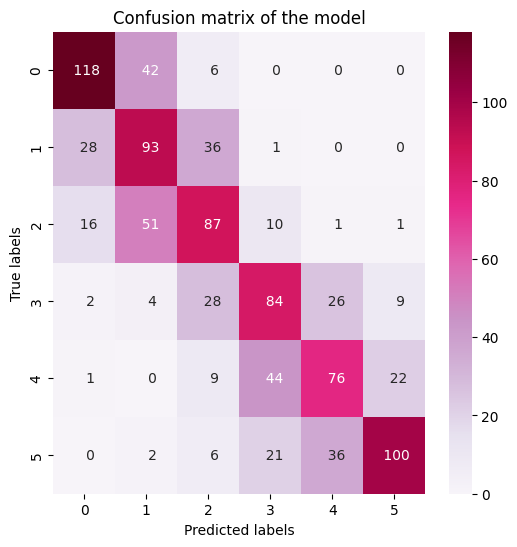

In [22]:
    import matplotlib.pyplot as plt
    import seaborn as sns
    # define the labels, plot and display the confusion matrix
    labels = list(unique_labels(y_test_list, test_predictions))
    cfm = confusion_matrix(y_test_list, test_predictions, labels = labels)
    fig, ax = plt.subplots(figsize=(6,6))
    plt.title('Confusion matrix of the model')
    sns.heatmap(cfm, annot=True, fmt='4g', cmap='PuRd', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

In [18]:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

y_test_list = y_test.tolist()

accuracy = accuracy_score(y_test_list, test_predictions)
precision = precision_score(y_test_list, test_predictions, average='macro')
recall = recall_score(y_test_list, test_predictions, average='macro')
f1 = f1_score(y_test_list, test_predictions, average='macro')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.58125
Precision: 0.5891131360239504
Recall: 0.579771261312766
F1 Score: 0.5819485107683964
